# DS - Application Project <br>
# Developement of a Recommender System for Employee Skills - Rated Approach

## Preprocessing

Packages:

In [161]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
# from sklearn.model_selection import train_test_split as scikit_train_test_split
from surprise import Reader, Dataset, accuracy
from surprise import NormalPredictor, BaselineOnly, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD, SVDpp, CoClustering, SlopeOne, NMF
from surprise.model_selection import KFold, GridSearchCV
# from surprise.model_selection import train_test_split as surprise_train_test_split
import time

Data import:

In [162]:
df = pd.read_csv("data/person-skills_2022-06-27.csv",sep=";")

Declare various aiding variables:

In [163]:
PERSONS = df["person"].unique()
SKILLS = sorted(df["skill"].unique())
CATEGORIES = df["category"].unique()

In [164]:
employee_dict = {}
for n in range(0,len(PERSONS)):
    employee_dict[n] = PERSONS[n]

In [165]:
skills_to_category = pd.read_csv("data/mitarbeiterportal-skills_2022-06-21.csv",sep=";",header=None)
category_dict = dict(zip(skills_to_category[0],skills_to_category[1]))

Since this notebook demonstrates the a recommender system which deals with rated skills and the underlying data does not offer ratings, this measure will be implemented in the following way: 
- For each skill, the frequency of the underlying category will be measured. The skills will be rated according to this frequency 
- For example: If an employee has most skills in the category "Programmiersprachen", these skills will receive the highest rating
- The ratings will be scaled to a range of 1 (being the lowest skill level) to 5 (being the highest skill level)

In [166]:
def scaler_1_5(x:float,old_max:int,old_min:int):
    '''
    Function scaling a value x to a range of 1 (minimum) and 5 (maximum) with respective to the previous min and max values of the structure x is embedded in. 
    ----------
    Parameters: 
    x : float
    The data which is to be scaled
    old_min : int 
    Min value of the structure x is embedded in.
    old_max : int 
    Max value of the structure x is embedded in.
    ----------
    Returns: 
    Scaled x. 
    '''
    old_range = (old_max - old_min)  
    if (old_range == 0):
        return 1
    else:
        new_range = (5 - 1) 
        x_std = (x - old_min)/(old_max-old_min)
        return round(x_std * new_range + 1)

In [168]:
def get_rated_df(data:pd.DataFrame):
    '''
    Function to add ratings to a skill dataset with underlying categories. 
    ----------
    Parameters: 
    data : pd.DataFrame
    The data with coulms: person, skill, category 
    ----------
    Returns: 
    Pandas DataFrame containing ratings for each skill according to underlying category frequency of skills. 
    '''
    category_per_employee = pd.DataFrame(index=data["category"].unique())
    df_rated = pd.DataFrame()
    for p in data["person"].unique():
        p_skills = data[data["person"] == p]
        # # count categories for each employee
        category_count = p_skills["category"].value_counts()
        category_count = category_count.apply(lambda x:scaler_1_5(x,category_count.max(),category_count.min()))
        category_count
        skill_values = np.array([])
        # # add count for each category to an array and 0 if category wasn't found (and therefore is not part of resptive employee's skillset)
        for cat in CATEGORIES:
            try:
                skill_values = np.append(skill_values,category_count[cat])
            except KeyError:
                skill_values = np.append(skill_values,0)
        # add employee data to dataframe
        p_skills_df = pd.DataFrame(index=CATEGORIES,columns=[p],data=skill_values)
        df_p_rated = pd.merge(data[data["person"] == p],p_skills_df,left_on="category",right_index=True).rename(columns={p:"rating"}).drop("category",axis=1)
        df_rated = pd.concat([df_rated,df_p_rated],ignore_index=True)
    return df_rated

In [170]:
df_rated = get_rated_df(df)

In [171]:
df_rated

,person,skill,rating
0,12,Windows NT/2000/XP,4.0
1,12,MAC OS X,4.0
2,12,Windows 7,4.0
3,12,Windows 8,4.0
4,12,iOS,4.0
...,...,...,...
24581,1488,Promotion / Drools Engine,5.0
24582,1488,Hybris,5.0
24583,1488,Apache JMeter,1.0
24584,1488,Keycloak,1.0


Since this notebook is dealing with rated skills and the used models should deal with the true ratings of the skills, no further transformation, such as normalization of ratings, will be applied.

## Surpirse Library - Model Selection

In this chapter, different recommender systems, making use of collaborative filtering and matrix factorization will be compared regardings their performance on the data. Afterwards the best performing model will be used for further evaluation. 

Convert the Pandas DataFrame into a data structure suitable for the surprise library. 

In [176]:
reader = Reader(rating_scale=(1,5)) 
data = Dataset.load_from_df(df_rated,reader)

Define number of trials of the cross validation and splits of the data:

In [177]:
NUM_TRIALS = 3
NUM_SPLITS = 5

Define cross validation procedure:

In [179]:
def gridsearch_cv_surprise(algo_class,algo_name:str,param_grid:dict,data,best_model_dict:dict,best_params_dict:dict):
    '''
    Function performing a cross-validation of given recommender algorithms from the surprise library. 
    ----------
    Parameters: 
    algo_class : surprise.prediction_algorithms
    The class of the recommender algorithm.
    algo_name : str
    Name of the respective algorithm.
    param_grid : dict
    Parameter option which will be tested and optimized in the cross validation. 
    data : surprise.dataset
    The underlying data which the recommendation should be performed on. 
    best_model_dict : dict
    Dictionary which will save a copy of the best model resulting from cross validation.
    best_params_dict : dict
    Dictionary which will save the best parameter combination resulting from cross validation.
    ----------
    Returns: 
    RMSE, MSE and MAE for each run performed in the cross validation. 
    '''
    start = time.time()
    rmse = np.zeros(NUM_TRIALS)
    mse = np.zeros(NUM_TRIALS)
    mae = np.zeros(NUM_TRIALS)
    models = []
    params = []

    for seed in range(NUM_TRIALS):
        print("Running CV for model", algo_name ,"in Iteration:", seed ,"at", time.time()-start)
        cv = KFold(
                        n_splits=NUM_SPLITS,
                        random_state=seed
                    )
        gs = GridSearchCV(
                        algo_class,
                        param_grid, 
                        measures=["rmse","mse","mae"], 
                        cv=cv,refit="rmse"
                    )
        gs.fit(data)
        rmse[seed] = gs.best_score["rmse"]
        mse[seed] = gs.best_score["mse"]
        mae[seed] = gs.best_score["mae"]
        models.append(gs.best_estimator["rmse"])
        params.append(gs.best_params["rmse"])

    # save the best model and parameter combination from all runs in the dictionaries
    best_model_dict[algo_name] = models[np.argmin(rmse)]
    best_params_dict[algo_name] = params[np.argmin(rmse)]

    print("Total time: ", (time.time()-start), "sec.")
    return rmse, mse, mae 

In [180]:
def add_result(results:pd.DataFrame, name:int, rmse, mse, mae):
    '''
    Function which saves results of cross validation in a DataFrame. 
    ----------
    Parameters: 
    results : pd.DataFrame
    DataFrame (empty or already containing results) which the results will be appended to. 
    name : str 
    Name of the algorithm of which the results are being protocolled. 
    rmse : array-like
    RMSE values from the cross validation.
    mse : array-like
    MSE values from the cross validation.
    mae : array-like
    MAE values from the cross validation. 
    ----------
    Returns: 
    Results DataFrame with an extra row containing the new results. 
    '''
    row = pd.DataFrame({
        "name":name,
        "rmse_mean":rmse.mean(), 
        "rmse_std":rmse.std(), 
        "mse_mean":mse.mean(), 
        "mse_std":mse.std(), 
        "mae_mean":mae.mean(), 
        "mae_std":mae.std()
        },index=[0])
    return pd.concat([results,row],ignore_index=True)

In [181]:
results = pd.DataFrame()
best_model_dict = {}
best_params_dict = {}

Define algorithms to be compared as well as their individual parameter grid:

In [182]:
algo_list = [
                (NormalPredictor,"Normal Predictor",{
                                    }),
                (BaselineOnly,"Baseline",{
                                                "verbose":[False]
                                    }),
                (KNNBasic,"k-NN",{
                                                "k": [20, 40, 60, 80],
                                                "min_k": [1, 5, 10, 20],
                                                "verbose":[False]
                                    }),
                (KNNWithMeans,"Centered k-NN",{
                                                "k": [20, 40, 60, 80],
                                                "min_k": [1, 5, 10, 20],
                                                "verbose":[False]
                                    }),
                (KNNWithZScore,"k-NN with z-score",{
                                                "k": [20, 40, 60, 80],
                                                "min_k": [1, 5, 10, 20],
                                                "verbose":[False]
                                    }),
                (KNNBaseline,"k-NN Baseline",{
                                                "k": [20, 40, 60, 80],
                                                "min_k": [1, 5, 10, 20],
                                                "verbose":[False]
                                    }),
                (SVD,"SVD",{
                                                "n_factors": [1, 2, 5, 10, 15, 20, 40],
                                                "n_epochs": [100, 200, 400, 800, 1000],
                                                "biased":[True,False],
                                                "random_state":[1]
                                    }),
                (SVDpp,"SVD++",{
                                                "n_factors": [1, 2, 5, 10, 15, 20, 40],
                                                "n_epochs": [100, 200, 500, 1000],
                                                "random_state":[1]
                                    }),
                (CoClustering,"CoClustering",{
                                                "n_cltr_u": [2, 3, 4],
                                                "n_cltr_i": [2, 3, 4],
                                                "n_epochs": [100, 200, 400, 800, 1000],
                                                "random_state":[1]
                                    }),
                (SlopeOne,"SlopeOne",{
                                    }),
                (NMF,"NMF",{
                                                "n_factors": [1, 2, 5, 10, 20, 40],
                                                "n_epochs": [20, 40, 80],
                                                "biased":[True,False],
                                                "random_state":[1]
                                    })
            ]

In [183]:
for algo in algo_list:
    rmse, mse, mae = gridsearch_cv_surprise(algo[0],algo[1],algo[2],data,best_model_dict,best_params_dict)
    results = add_result(results,algo[1],rmse, mse, mae)

Running CV for model Normal Predictor in Iteration: 0 at 0.0
Running CV for model Normal Predictor in Iteration: 1 at 0.2880260944366455
Running CV for model Normal Predictor in Iteration: 2 at 0.517019510269165
Total time:  0.7564935684204102 sec.
Running CV for model Baseline in Iteration: 0 at 0.0
Running CV for model Baseline in Iteration: 1 at 0.23705482482910156
Running CV for model Baseline in Iteration: 2 at 0.4650580883026123
Total time:  0.6960556507110596 sec.
Running CV for model k-NN in Iteration: 0 at 0.0
Running CV for model k-NN in Iteration: 1 at 25.66473078727722
Running CV for model k-NN in Iteration: 2 at 49.97932195663452
Total time:  69.62827205657959 sec.
Running CV for model Centered k-NN in Iteration: 0 at 0.0
Running CV for model Centered k-NN in Iteration: 1 at 21.91366457939148
Running CV for model Centered k-NN in Iteration: 2 at 43.7615864276886
Total time:  65.8282196521759 sec.
Running CV for model k-NN with z-score in Iteration: 0 at 0.0
Running CV for 

In [184]:
results

,name,rmse_mean,rmse_std,mse_mean,mse_std,mae_mean,mae_std
0,Normal Predictor,1.725026,0.007070,2.975882,0.024369,1.399650,0.006642
1,Baseline,0.954836,0.000799,0.911758,0.001546,0.757934,0.000558
2,k-NN,0.804532,0.001392,0.647372,0.002274,0.587226,0.001154
3,Centered k-NN,0.804263,0.001699,0.646981,0.002806,0.590117,0.001550
4,k-NN with z-score,0.805470,0.001331,0.648922,0.002191,0.585014,0.001424
5,k-NN Baseline,0.782887,0.001023,0.613029,0.001648,0.571576,0.001016
6,SVD,0.475560,0.004849,0.226368,0.004630,0.268605,0.002320
7,SVD++,0.487273,0.000878,0.237659,0.000905,0.279709,0.001137
8,CoClustering,0.877156,0.004443,0.769594,0.007927,0.655739,0.002938
9,SlopeOne,0.883957,0.000525,0.781480,0.000937,0.672960,0.000363


In [314]:
best_params_dict

{'Normal Predictor': {},
 'Baseline': {'verbose': False},
 'k-NN': {'k': 20, 'min_k': 1, 'verbose': False},
 'Centered k-NN': {'k': 20, 'min_k': 1, 'verbose': False},
 'k-NN with z-score': {'k': 20, 'min_k': 1, 'verbose': False},
 'k-NN Baseline': {'k': 20, 'min_k': 1, 'verbose': False},
 'SVD': {'n_factors': 40,
  'n_epochs': 1000,
  'biased': False,
  'random_state': 1},
 'SVD++': {'n_factors': 20, 'n_epochs': 1000, 'random_state': 1},
 'CoClustering': {'n_cltr_u': 4,
  'n_cltr_i': 4,
  'n_epochs': 100,
  'random_state': 1},
 'SlopeOne': {},
 'NMF': {'n_factors': 40, 'n_epochs': 80, 'biased': False, 'random_state': 1}}

Both SVD and SVD++ show significantly smaller error values compared to the other models in the comparison

Define holdout data: <br>
Since the recommendations of this approach should be comparable to the results of the binary approach, we need a uniform measure of comparison. One measure, which presents itself as suitable, is the precision of the recommendations. In other words, we want to measure in how far the recommender system will tend to recommend skill to our employee, which these employees would actually want to learn. To do so, 10% of high rated skills will be removed from the data prior to training the model and will be stored as holdout. During evaluation, the occurence of these exact skills among the recommendations will be measured. If the recommender system recommends skills to employee, which are in the holdout, meaning that the employee actually already knows this skill and also has a high rating asserted to it, we do have an objective measurement which validates the recommendations as meaningful. 

In [ ]:
def get_rare_skills(data:pd.DataFrame,n:int):
    '''
    Function to determine all skills which occur less than n times in a given dataset.
    Dataset must be a pandas Dataframe with columns: person, skill.
    ----------
    Parameters: 
    data : pd.DataFrame
    The data in which rare skills are to be determined. 
    n : int 
    The threshold frequency.
    ----------
    Returns: 
    List of skills occuring less than n times in dataset.
    '''
    skill_frequency = {}
    for skill in data["skill"].unique():
        skill_frequency[skill] = data[data["skill"] == skill]["person"].nunique()

    return [s for s,f in skill_frequency.items() if f <= n]

In [ ]:
def get_holdout(data:pd.DataFrame,size:float):
    '''
    Function extracting high rated skills from rated data and storing these entries in a separate DataFrame. 
    ----------
    Parameters: 
    data : pd.DataFrame
    The rated data. 
    n : int 
    amount of entries to be pruned from data (e. g. size = 0.1 --> 10% of entries will be taken out).
    ----------
    Returns: 
    DataFrame containing holdout data. 
    '''
    # save original size of data for termination of while loop 
    size_data = len(data)
    holdout = pd.DataFrame()
    # get list which represents each employee with their number of entered skills in the data
    employee_occurence = data["person"].to_list()
    rare_skills = get_rare_skills(df_rated,5)
    # initialize random seed
    seed = 0 
    while len(holdout)/size_data < size:
        # randomly select employee (affected by how often they occur in the data)
        np.random.seed(seed)
        df_subset_emp = data[(data["person"] == np.random.choice(employee_occurence))]
        # prune rare skills from dataset so skills do not get randomly eliminated from training data
        df_subset_pruned = df_subset_emp[~df_subset_emp["skill"].isin(rare_skills)]
        # if condition causes that employee do not get completely deleted from dataset
        if len(df_subset_pruned) > 1:
            max_rating_emp = df_subset_pruned["rating"].max()
            holdout_emp = df_subset_pruned[df_subset_pruned["rating"] == max_rating_emp].sample(n=1,random_state=seed)
            data.drop(holdout_emp.index,inplace=True)
            holdout = pd.concat([holdout,holdout_emp],ignore_index=True)
        # change seed for next while iteration
        seed = seed + 1
    return holdout

In [ ]:
holdout = get_holdout(df_rated,0.05)
holdout

Reload dataset, now pruned for holdout data:

In [ ]:
data = Dataset.load_from_df(df_rated,reader)

Select best performing model and fit it on full data:

In [224]:
#model = NMF(n_factors= 40, n_epochs = 120, biased = False, random_state= 1)
#model = SVD(n_factors = 40, n_epochs = 1000, biased = False, random_state = 1)
model = best_model_dict[results.iloc[results["rmse_mean"].idxmin()]["name"]]
trainset = data.build_full_trainset()
model.fit(trainset)

Predict ratings for all skills which the employees do not yet have (meaning which do not have an existing rating):

In [225]:
preds = model.test(trainset.build_anti_testset())

Define functions to extract recommendations from preds object

In [226]:
def get_top_n(predictions:list, n:int):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = {}
    
    for uid, iid, true_r, est, _ in predictions:
        try:
                top_n[uid].append((iid, est))
        except KeyError:
                top_n[uid] = [(iid, est)]

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [227]:
def get_recommendations(preds:list,n:int):
    '''
    Function returning recommendations for all users in given prediction list.  
    ----------
    Parameters: 
    preds : list
    List containing predictions.  
    n : int 
    Amount of predictions to be shown for each user is prediciton list.
    ----------
    Returns: 
    DataFrame containing predictions.  
    '''
    top_n = get_top_n(preds, n)
    recommendations = pd.DataFrame()

    for uid, user_ratings in top_n.items():
        recom = pd.DataFrame(index=[uid],data=[[iid for (iid, _) in user_ratings]])
        recommendations = pd.concat([recommendations,recom])

    return recommendations

## Evaluation

#### Evaluation Using Precision Scores

Define precision measures: 

In [228]:
def precision_at_k(k:int,holdout:pd.DataFrame,recommendations:pd.DataFrame):
    '''
    Function computing precision at k on given recommendations and holdout data.  
    ----------
    Parameters: 
    k : int
    The amount of predictions to be observed. 
    holdout : pd.DataFrame
    The holdout data.
    recommendations : pd.DataFrame
    The recommendations
    ----------
    Returns: 
    Precision at k.  
    '''
    precision = np.zeros(holdout["person"].nunique())
    
    for i,emp in enumerate(holdout["person"].unique()):
        holdout_emp = holdout[holdout["person"] == emp]["skill"].to_list()
        recoms_emp = recommendations.loc[emp].to_list()

        if len(recoms_emp)>k:
            recoms_emp = recoms_emp[:k]

        score = 0

        for recom in recoms_emp:
            if recom in holdout_emp:
                score = score + 1

        precision[i] = score/min(len(holdout_emp),k)

    return np.mean(precision)

In [312]:
def mean_average_precision(k,holdout,recommendations):
    '''
    Function computing mean average precision at k on given recommendations and holdout data.  
    ----------
    Parameters: 
    k : int
    The amount of predictions to be observed. 
    holdout : pd.DataFrame
    The holdout data.
    recommendations : pd.DataFrame
    The recommendations
    ----------
    Returns: 
    Mean average precision at k.  
    '''
    precision = np.zeros(holdout["person"].nunique())

    for i,emp in enumerate(holdout["person"].unique()):
        holdout_emp = holdout[holdout["person"] == emp]["skill"].to_list()
        recoms_emp = recommendations.loc[emp].to_list()

        if len(recoms_emp)>k:
            recoms_emp = recoms_emp[:k]

        score = 0
        num_hits = 0

        for j,recom in enumerate(recoms_emp):
            if recom in holdout_emp:
                num_hits = num_hits + 1
                score = score + (num_hits / (j+1))

        precision[i] = score/min(len(holdout_emp),k)

    return np.mean(precision)

In [230]:
precision_at_k(10,holdout,get_recommendations(preds,10))

0.5410175387027238

The above precision telss us that on average, around 5-6 recommendations of the top 10 recommencations fou a user are skills which are in the holdout, therefore skills the respective employee already knows. 

In [313]:
mean_average_precision(10,holdout,get_recommendations(preds,10))

0.2549446632505311

The weighted precision at k takes the order in which the recommendations are given into account. 

#### Evaluation Using Top Skills and Skill Categories of Employees

In [232]:
def evaluate_employee_recoms(userid:int,n:int):
    '''
    Function showing recommendation along with actually possessed skills and categories to provide some context.  
    ----------
    Parameters: 
    userid : int
    The user id of the employee who's recommendation are to be evaluated.  
    n : int 
    Amount recommendation and skills to be shown. 
    ----------
    Returns: 
    DataFrame containing recommendations and actually possessed skills.  
    '''
    fig, axes = plt.subplots(2,1,figsize=(10,8))
    # get categories of actual skills
    skill_catgegories = df[df["person"] == userid]["category"].value_counts()
    skill_catgegories.plot(ax=axes[0],
                            kind="barh",
                            #ylabel="Count",
                            title="Category Count of Actual Skills - Employee "+str(userid),
                            color="#112e51",
                            edgecolor='k',
                            alpha=0.8)
    top_n_skills = df_rated[df_rated["person"] == userid].sort_values(by="rating",ascending=False).head(n).reset_index()[["skill"]]
    # get categories of recommended skills
    recoms_for_emp = pd.DataFrame(get_recommendations(preds,n).loc[userid].T)
    recoms_catgories = recoms_for_emp.replace({userid:category_dict}).value_counts()
    indeces = []
    for index in recoms_for_emp.replace({userid:category_dict}).value_counts().index:
        indeces.append(index[0])
    recoms_catgories.index = indeces
    recoms_catgories.plot(ax = axes[1],
                            kind = "barh",
                            xticks = np.arange(0,recoms_catgories.max()+1,1),
                            #ylabel="Count",
                            title = "Category Count of Recommended Skills - Employee "+str(userid),
                            color="#112e51",
                            edgecolor='k',
                            alpha=0.8)
    # create of top skills and recommendation for better comparison
    return_table = pd.concat([top_n_skills,recoms_for_emp],axis=1,ignore_index=True)
    return_table.columns = ["Top " + str(n) + " Actual Skills","Recommendations"]
    return return_table

12, 43, 59

In [296]:
holdout[holdout["person"] == 12]

,person,skill,rating
321,12,Behaviour Driven Development (BDD),5.0
468,12,Dependency Injection,5.0


,Top 10 Actual Skills,Recommendations
0,Unit Tests (Komponententests),pycharm
1,Agile Methoden,Dependency Injection
2,Statische Codeanalyse,Swing/AWT
3,Continuous Integration (CI),Behaviour Driven Development (BDD)
4,Objektrelationale Abbildung (ORM),Aspektorientierte Programmierung (AOP)
5,Test Driven Development (TDD),WebDynpro
6,Windows NT/2000/XP,Castor
7,MAC OS X,MVS
8,Spring Boot,Oracle XDK
9,Spring,TopLink


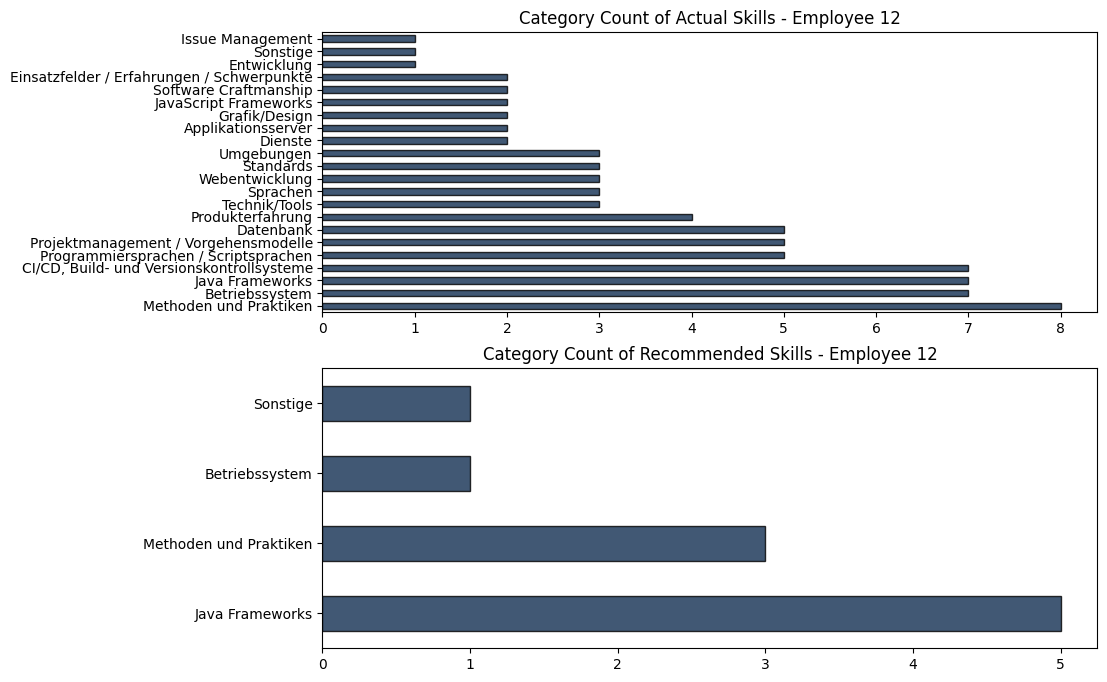

In [294]:
evaluate_employee_recoms(12,10)

#### Evaluation Using Commonly Used Baselines

##### Surprise's Baseline

In [195]:
baseline = BaselineOnly(verbose=False)
baseline.fit(trainset)
baseline_preds = baseline.test(trainset.build_anti_testset())

In [196]:
baseline_recommendations = get_recommendations(baseline_preds,10)
baseline_recommendations

,0,1,2,3,4,5,6,7,8,9
12,Jakarta Commons,EJB 3,TestNG,Struts 2,JSF,Struts (bis Version 1.3),Servlet/JSP,TopLink,Vue.js,Velocity
13,Jakarta Commons,EJB 3,TestNG,Struts 2,JSF,Hibernate,Spring,JDBC,Log4J,Struts (bis Version 1.3)
15,Jakarta Commons,EJB 3,TestNG,Struts 2,JSF,Hibernate,Spring,JDBC,Log4J,Struts (bis Version 1.3)
16,Jakarta Commons,EJB 3,TestNG,Struts 2,JSF,Hibernate,Spring,JDBC,Log4J,Struts (bis Version 1.3)
17,Jakarta Commons,EJB 3,TestNG,Struts 2,JSF,Hibernate,Spring,JDBC,Log4J,Struts (bis Version 1.3)
...,...,...,...,...,...,...,...,...,...,...
1467,Jakarta Commons,EJB 3,TestNG,Struts 2,JSF,Hibernate,Spring,JDBC,Log4J,Struts (bis Version 1.3)
1474,Jakarta Commons,EJB 3,TestNG,Struts 2,JSF,Hibernate,Spring,JDBC,Log4J,Struts (bis Version 1.3)
1475,Jakarta Commons,EJB 3,TestNG,Struts 2,JSF,Hibernate,Spring,JDBC,Log4J,Struts (bis Version 1.3)
1479,Jakarta Commons,EJB 3,TestNG,Struts 2,JSF,Hibernate,Spring,JDBC,Log4J,Struts (bis Version 1.3)


In [197]:
precision_at_k(10,holdout,baseline_recommendations) 

0.15095899470899474

In [198]:
mean_average_precision(10,holdout,baseline_recommendations) 

0.07454285129117948

##### Most Often Occurring Skills

In [199]:
most_common_skills = list(df["skill"].value_counts().nlargest(10).index)

recom_list = []
for person in range(0,len(PERSONS)):
    recom_list.append(most_common_skills)

baseline_2_recoms = pd.DataFrame(index=PERSONS,columns=np.arange(0,10),data=recom_list)
baseline_2_recoms

,0,1,2,3,4,5,6,7,8,9
12,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,Test Driven Development (TDD)
13,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,Test Driven Development (TDD)
15,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,Test Driven Development (TDD)
16,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,Test Driven Development (TDD)
17,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,Test Driven Development (TDD)
...,...,...,...,...,...,...,...,...,...,...
1467,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,Test Driven Development (TDD)
1474,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,Test Driven Development (TDD)
1475,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,Test Driven Development (TDD)
1479,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,Test Driven Development (TDD)


In [200]:
precision_at_k(10,holdout,baseline_2_recoms)

0.06500587889476778

In [201]:
mean_average_precision(10,holdout,baseline_2_recoms)

0.01234426032072637

## Recommendations

Get recommendations for all users in database: 

In [202]:
all_recomms = get_recommendations(preds,5)
all_recomms

,0,1,2,3,4
12,pycharm,Dependency Injection,Swing/AWT,Behaviour Driven Development (BDD),Aspektorientierte Programmierung (AOP)
13,Windows Communication Foundation (WCF),Windows Identity Foundation (WIF),Kendo UI,DevExpress,Microsoft Enterprise Library
15,Vue.js,Cypress,ITCSS,Angular Material,Storybook
16,React,ITCSS,"Layouting (Flexbox, CSS Grid)",Ajax,Cypress
17,Windows Forms,ADO.NET,LINQ,Windows Workflow Foundation (WF),ASP.NET MVC-Framework
...,...,...,...,...,...
1467,Python,Delphi,TypoScript,Pascal,C/C++
1474,HTML5,jQuery,Bootstrap,Web Components,Redux
1475,Unit Tests (Komponententests),Objektrelationale Abbildung (ORM),Statische Codeanalyse,StyleReport,Java FX
1479,Kendo UI,Windows Forms,Windows Communication Foundation (WCF),ASP.NET,ASP Generalist


Get recommendations for one or many individual users:

In [203]:
def get_recommendations_for_employee(userids:list,n:int): 
    '''
    Function showing the top n recommendation for one or multiple users.  
    ----------
    Parameters: 
    userid : int
    The user id of the employee who's recommendation are to be evaluated.  
    n : int 
    Amount recommendation and skills to be shown. 
    ----------
    Returns: 
    DataFrame containing recommendations, predicted ratings and corresponding categories.   
    '''
    recommendation_df = pd.DataFrame()
    for user in userids: 
        recoms_for_user = pd.DataFrame(get_top_n(preds, n)[user],columns=["skill","rating"],index=[user for i in range(0,n)])
        recommendation_df = pd.concat([recommendation_df,recoms_for_user])
    recommendation_df["category"] = recommendation_df["skill"].apply(lambda x:category_dict[x])
    return recommendation_df

In [204]:
userids = [12,54]
get_recommendations_for_employee(userids,5)

,skill,rating,category
12,pycharm,5.000000,Sonstige
12,Dependency Injection,4.776088,Methoden und Praktiken
12,Swing/AWT,4.775965,Java Frameworks
12,Behaviour Driven Development (BDD),4.713013,Methoden und Praktiken
12,Aspektorientierte Programmierung (AOP),4.600613,Methoden und Praktiken
54,pycharm,4.078480,Sonstige
54,IT Consulting,3.763674,Beratung
54,Symbian,3.713585,Betriebssystem
54,Management Consulting,3.621001,Beratung
54,AS400,3.615930,Betriebssystem


### Recommendations for New Employees

In [292]:
new_id = 8774
new_skills = {
                "Englisch":4,
                "Python":5,
                "MySQL":4,
                "MongoDB":1,
                "vs code":4,
                "Docker":2,
                "GIT":2,
                "GitHub":2
            }

In [268]:
def get_recoms_for_new_employee(new_id:int,new_skills:dict,n:int):
    '''
    Function showing recommendation along with actually possessed skills and categories to provide some context.  
    The data will be added to the data base and the model is retrained on the enlarged dataset. 
    ----------
    Parameters: 
    new_id : int
    The id of the user which is to be added to the database. 
    new_skills : dict
    Dictionary containing skills as keys and corresponding rating as values.   
    n : int 
    Amount recommendation and skills to be shown. 
    ----------
    Returns: 
    Top n recommendations of new user.   
    '''
    if new_id in PERSONS:
        return "Error: ID already taken. Please choose a different ID an try again."
    for skill in new_skills.keys():
        if skill not in SKILLS:
            return "Skill " + skill + " not in database."
            # COMMENT: this is only a placeholder. For ideas on how to handle new skills, see "HOW TO HANDLE NEW SKILL" section 

    new_employee_df = pd.DataFrame()
    new_employee_df["skill"] = new_skills.keys()
    new_employee_df["rating"] = new_skills.values()
    new_employee_df["person"] = new_id
    new_employee_df = new_employee_df[["person","skill","rating"]]

    df_rated_new = pd.concat([df_rated,new_employee_df],ignore_index=True)
    # COMMENT: right now this function creates a new rated df. In order for this to retain newly added employees, it needs to overwrite the old df with the new data. 
    # this had to be implemented later on

    new_data = Dataset.load_from_df(df_rated_new,reader)

    model = best_model_dict[results.iloc[results["rmse_mean"].idxmin()]["name"]]
    #  COMMENT: right now the best model from the initial gridearch is taken. if the model is indeed to be retrained, it should be executing a new gridsearch and take the best estimator from this one
    trainset = new_data.build_full_trainset()
    model.fit(trainset)

    testset = trainset.build_anti_testset()
    predictions = model.test(testset)

    return get_top_n(predictions, n)[new_id]

In [293]:
get_recoms_for_new_employee(new_id,new_skills,5)

[('OpenShop', 5),
 ('Swing/AWT', 4.844331787798043),
 ('Jogl', 4.82783655147587),
 ('Ruby', 4.8182744714887225),
 ('C#', 4.814542599700227)]

## Conclusion

As shown in this notebook, the predicitons performed by SVD with params () score an average RMSE of 0.475560 during the cross validation, which means that the predicted scores are off by less than half a rating point. In regards to the rating range (1 - 5), the error can be seen as moderately low. Therefore, recommendations made using the demonstrated set up have a high potential of fulfilling the desired task, which is the recommendation of skills to a user which other similar users possess. <br>
However, certain limitations of this approach should be considered when implementing the rated approach. First of all, the most prominent downside of this approach is that the artificially created ratings have a major impact on the recommendations. Due to the fact, that a users' skill with the highest rating will always be out of one and the same category, the recommendations have a high likelihood to also be skills of the same category.

In [319]:
occurence = np.zeros(len(PERSONS))
for i,p in enumerate(PERSONS):
    main_cat = df[df["person"] == p]["category"].value_counts().index[0]
    recommended_cat = get_recommendations_for_employee([p],10)["skill"].apply(lambda x : category_dict[x]).to_numpy()
    count = 0
    for cat in recommended_cat:
        if cat == main_cat:
            count += 1
    occurence[i] = count

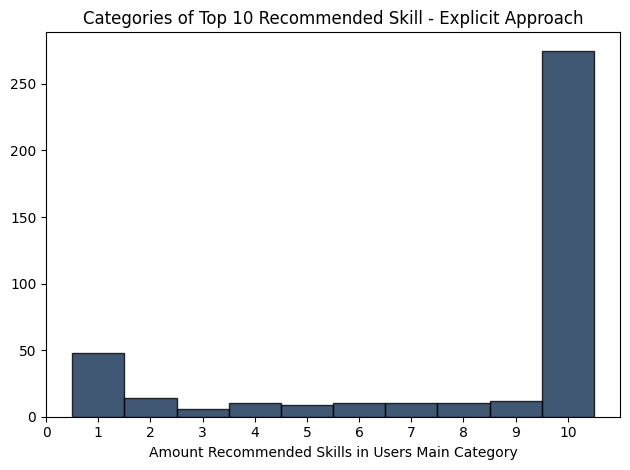

In [333]:
plt.hist(occurence,color="#112e51",alpha=0.8,edgecolor='k',bins=range(11),align="right")
plt.title("Categories of Top 10 Recommended Skill - Explicit Approach")
plt.xlabel("Amount Recommended Skills in Users Main Category")
plt.xticks(np.arange(0,11,1))
plt.tight_layout()
plt.savefig("Category Hist")

## Appendix I - Effect of Dropping Rare Skills on Recommender Precision


In order to observe the effect of dropping rare skills from the dataset and therefore making the data less dense, possibly improving the performance of the matrix factorization procedure, we will conduct the experiment multiple times while dropping skills which don't meet various absolute support thresholds in the dataset (absolute support represents the number of times the skill occurs in the dataset).

In [210]:
min_absolute_support = [0, 1, 2, 5, 10, 20]

In [211]:
def measure_performance_for_n(n:int):
    '''
    Function measuring the effect of dropping skills from the dataset which occur n or less times.   
    ----------
    Parameters:   
    n : int 
    Minimum absolute support threshold for skills to be dropped.   
    ----------
    Returns: 
    DataFrame containing performance measures such as sparsity, p@k and rmse for given n.  
    '''
    df = pd.read_csv("data/person-skills_2022-06-27.csv",sep=";")
    # trim dataset according to min absolute support of skills and insert ratings afterwards
    rare_skills = get_rare_skills(df,n)
    df_rated = get_rated_df(df[~df["skill"].isin(rare_skills)])
    # measure sparsity (ratio between non-zero and zero value entries)
    sparsity = 1-(len(df_rated)/(df_rated["person"].nunique()*df_rated["skill"].nunique()))
    # get holdout for later precision measurement 
    holdout = get_holdout(df_rated,0.05)
    # transform data to surprise dataset
    reader = Reader(rating_scale=(1,5))
    data = Dataset.load_from_df(df_rated,reader)
    algo = (SVD,"SVD",{
                        "n_factors": [1, 2, 5, 10, 15, 20, 40],
                        "n_epochs": [100, 200, 400, 800, 1000],
                        "biased":[True,False],
                        "random_state":[1]
                                        })
    best_model_dict = {}
    best_params_dict = {}
    rmse, mse, mae = gridsearch_cv_surprise(algo[0],algo[1],algo[2],data,best_model_dict,best_params_dict)
    # define model, fit and test it on the data
    model = best_model_dict["SVD"]
    trainset = data.build_full_trainset()
    model.fit(trainset)
    preds = model.test(trainset.build_anti_testset())
    # save performance measures in df
    return pd.DataFrame({
                "n":n,
                "unique_skills":df_rated["skill"].nunique(),
                "sparsity":sparsity,
                "precision_at_k":precision_at_k(10,holdout,get_recommendations(preds,10)),
                "mean_average_precision":mean_average_precision(10,holdout,get_recommendations(preds,10)),
                "SVD - n_factors":best_params_dict["SVD"]["n_factors"],
                "SVD - mean rmse": np.mean(rmse),
                "SVD - mean mse": np.mean(mse),
                "SVD - mean mae": np.mean(mae)
                },index=[0])

In [212]:
result_df = pd.DataFrame()#columns = ["n","sparsity","precision_at_k","weighted_precision_at_k","SVD - n_factors"])
for n in min_absolute_support:
    result_df = pd.concat([result_df,measure_performance_for_n(n)],ignore_index=True)
result_df

Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 289.2978768348694
Running CV for model SVD in Iteration: 2 at 574.7142314910889
Total time:  862.035483121872 sec.
Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 291.406884431839
Running CV for model SVD in Iteration: 2 at 581.5231790542603
Total time:  874.5650629997253 sec.
Running CV for model SVD in Iteration: 0 at 0.0010006427764892578
Running CV for model SVD in Iteration: 1 at 291.21767592430115
Running CV for model SVD in Iteration: 2 at 583.9045548439026
Total time:  891.1521050930023 sec.
Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 303.1967258453369
Running CV for model SVD in Iteration: 2 at 588.6008150577545
Total time:  873.5230040550232 sec.
Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 274.2815456390381
Running CV for model SVD in Iteration: 2 

,n,unique_skills,sparsity,precision_at_k,weighted_precision_at_k,SVD - n_factors,SVD - mean rmse,SVD - mean mse,SVD - mean mae
0,0,734,0.917089,0.460261,0.211473,20,0.473774,0.224719,0.266529
1,1,665,0.908521,0.511547,0.248245,40,0.461308,0.213017,0.261526
2,2,614,0.901101,0.501121,0.254197,40,0.449384,0.202052,0.256867
3,5,510,0.882889,0.554174,0.265991,40,0.425817,0.181433,0.245200
4,10,392,0.853275,0.654780,0.332526,40,0.401620,0.161485,0.232379
5,20,270,0.801940,0.767028,0.414437,40,0.386230,0.149451,0.214500


Observations: <br>
In general, we observe that the more skills are dropped from the data, the higher the precision at k of the predictions. As expected, SVD performs better with increasing density of the user-item matrix, indicated by decresing error measures RMSE, MSE and MAE with rising. This leads to the assumption, that elimiting rare items from the data bears the protential of increasing the models' performance. <br>
However, with n being set to 5, there are already more than 200 skills being pruned from the dataset. For n = 20, more than 500 skills are lost in the pruning procedure. Naturally, these skills will not be part of any recommendations, possibly decreasing the quality of the predictions as such. <br>
To conclude, while pruning skills from the dataset prior to using the model potentially increases model performance, the user should bear in mind to not set the minimum support threshold too high, as this will lead to a high amount of skills not being part of the resulting recommendations.

## Appendix II - Reverse Problem for User Recommendations on Items

In [213]:
df_items = df_rated[["skill","person","rating"]].sort_values(by="skill")
reader = Reader(rating_scale=(1,5)) 
data_items = Dataset.load_from_df(df_items,reader)
model = SVD(n_factors = 40, n_epochs = 1000, biased = False, random_state = 1)
trainset = data_items.build_full_trainset()
model.fit(trainset)

In [214]:
preds = model.test(trainset.build_anti_testset())

In [215]:
get_top_n(preds,10)["Python"]

[(215, 4.8648364715376715),
 (1467, 4.850964672288949),
 (631, 4.848390217671857),
 (147, 4.842250341848838),
 (1290, 4.8388572718574245),
 (272, 4.828183884593311),
 (957, 4.798802956813434),
 (172, 4.788088263930765),
 (1278, 4.769069794875521),
 (204, 3.96683095679537)]

In [216]:
df[df["person"] == 1467]["category"].value_counts()

Programmiersprachen / Scriptsprachen    3
Betriebssystem                          2
Datenbank                               1
Java Frameworks                         1
Webentwicklung                          1
Name: category, dtype: int64